<a href="https://www.kaggle.com/code/yasinsoylu123/apple-stock-price-time-series-and-lstm?scriptVersionId=124234902" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot")

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error

import warnings
import warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

In [2]:
df = pd.read_csv('../input/apple-stock-price-from-19802021/AAPL.csv') # Load Dataset

# **Data Preprocessing**

In [3]:
df # Check overall data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900


In [4]:
df.isna().mean() # Checking the null value

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

> **Okay, there's no null value, great job**

In [5]:
df["Date"]=pd.to_datetime(df.Date,dayfirst=True)
df.set_index("Date",inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...
2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000


In [6]:
df=df.asfreq("d")
df = df.fillna(method  = "bfill")

Text(0, 0.5, 'open price')

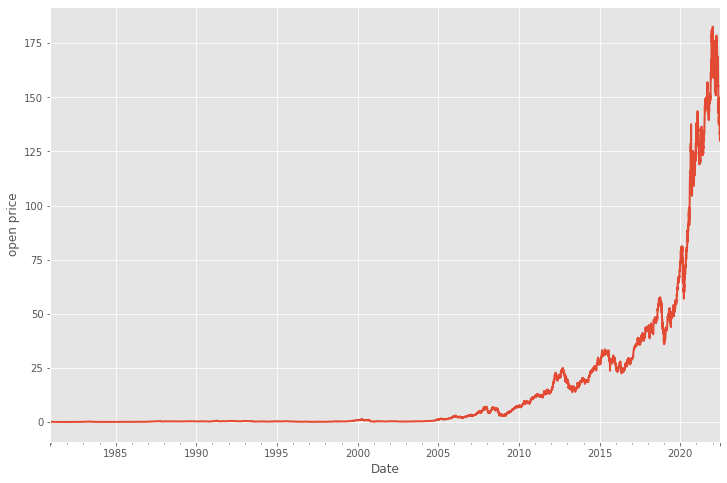

In [7]:
df['Open'].plot(figsize=(12,8))
plt.ylabel("open price")

Text(0, 0.5, 'Volume price')

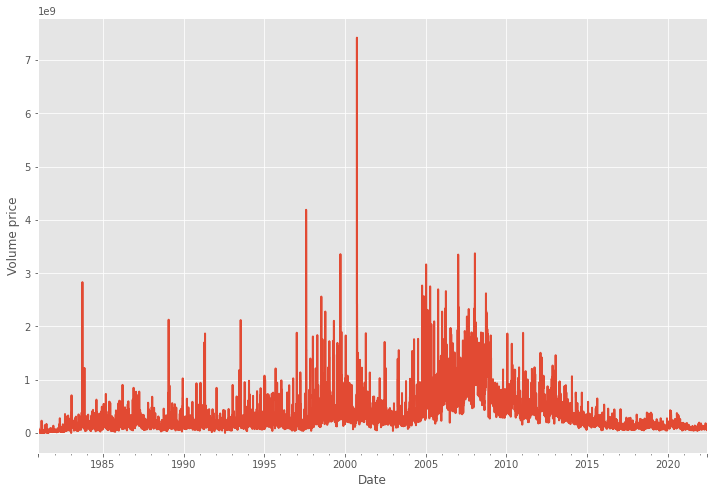

In [8]:
df['Volume'].plot(figsize=(12,8))
plt.ylabel("Volume price")

In [9]:
df['Total Pos'] = df.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

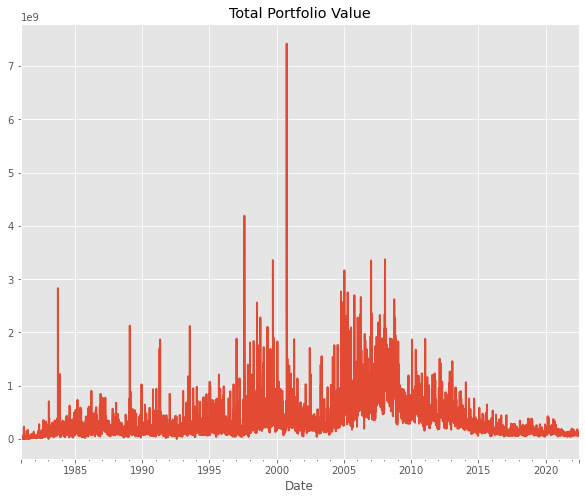

In [10]:
df['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

In [11]:
df['Daily Return'] = df['Total Pos'].pct_change(1)

In [12]:
df['Daily Return'].mean()

8745.781926404072

<AxesSubplot:ylabel='Density'>

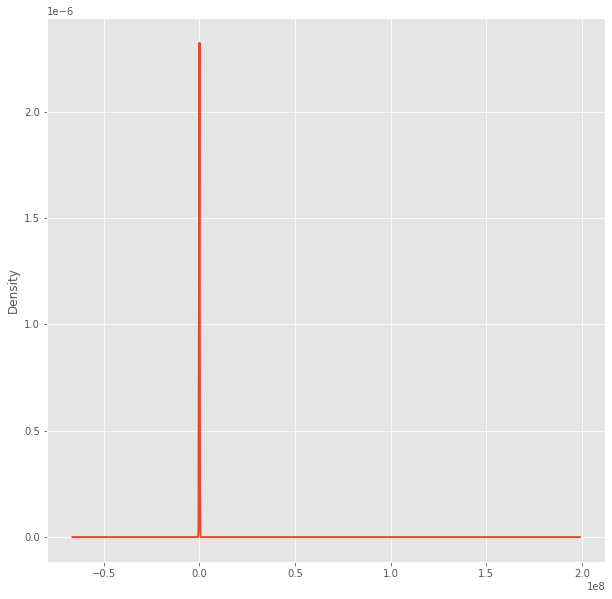

In [13]:
df['Daily Return'].plot(kind='kde')

In [14]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()


<AxesSubplot:xlabel='Date'>

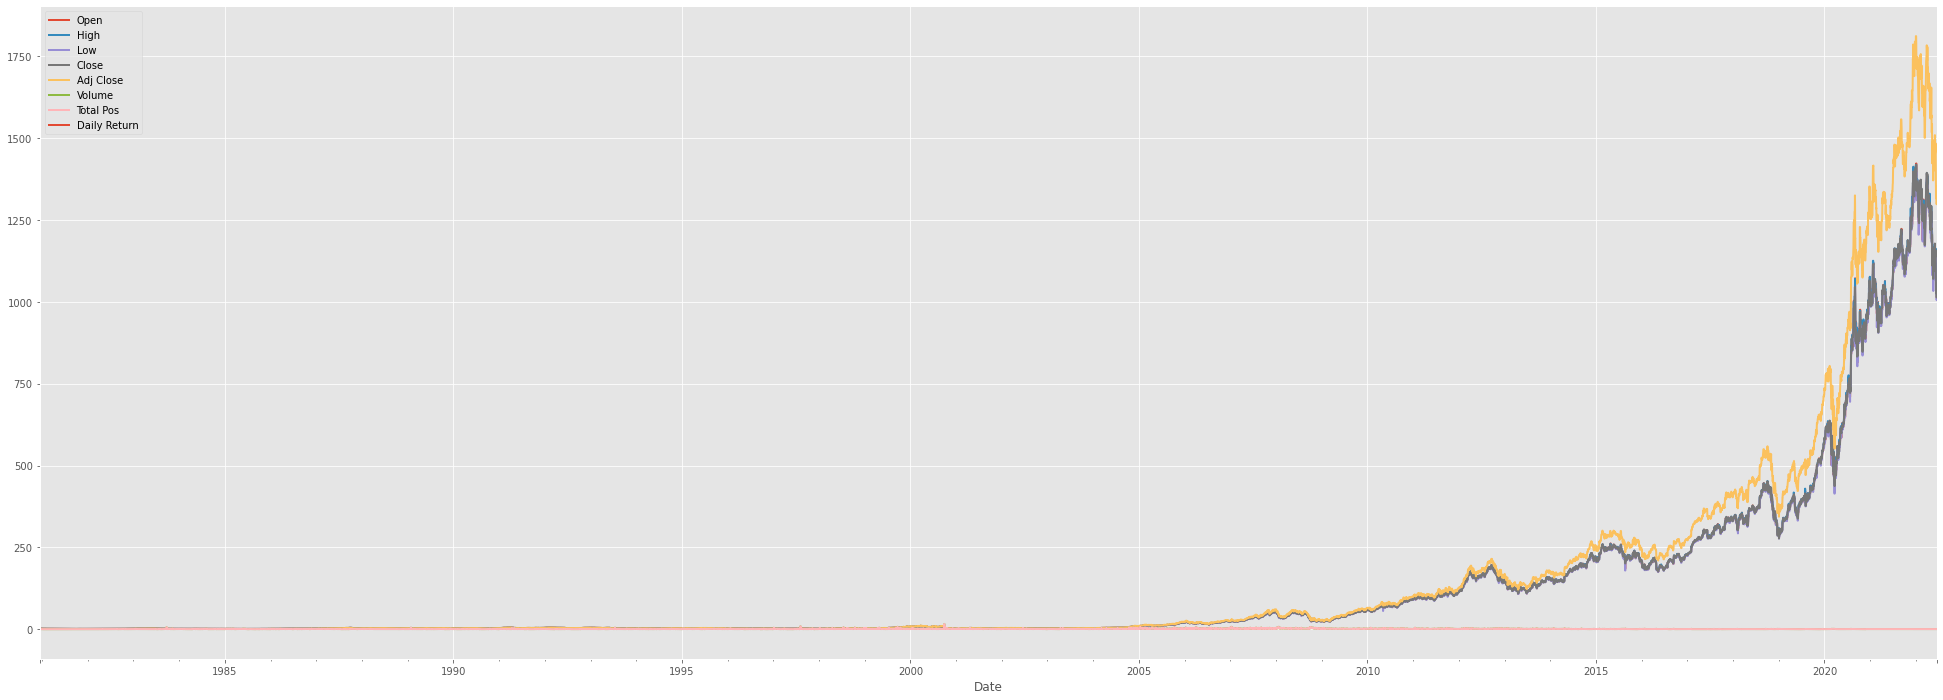

In [15]:
all_plot = df/df.iloc[0]
all_plot.plot(figsize=(34,12))

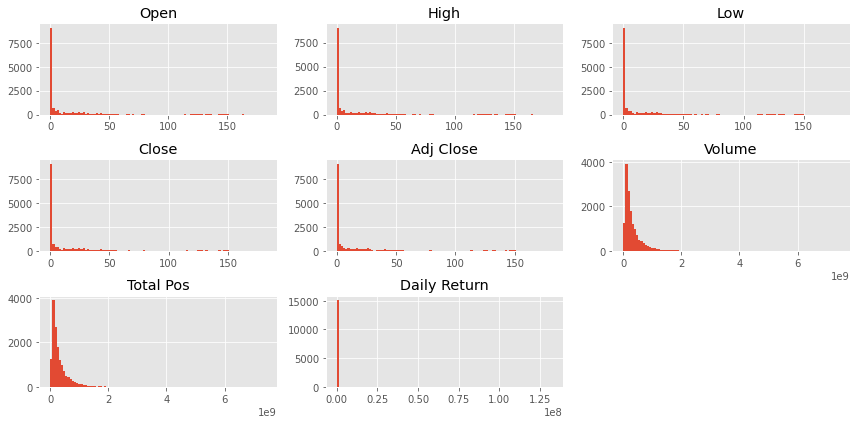

In [16]:
df.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [17]:
df.resample(rule='A').mean()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return
Date,,,,,,,,
1980-12-31,0.137891,0.138281,0.137723,0.137723,0.107496,1.006622e+08,1.006622e+08,-0.081828
1981-12-31,0.108939,0.109297,0.108585,0.108585,0.084753,3.219831e+07,3.219831e+07,363293.775812
1982-12-31,0.085491,0.086622,0.084597,0.085390,0.066649,7.955891e+07,7.955891e+07,0.100908
1983-12-31,0.167658,0.171274,0.163520,0.167363,0.130631,1.705623e+08,1.705623e+08,0.499909
1984-12-31,0.119775,0.122088,0.117448,0.119555,0.093316,1.614866e+08,1.614866e+08,0.095141
1985-12-31,0.091026,0.091943,0.089874,0.090127,0.070346,1.732520e+08,1.732520e+08,0.120049
1986-12-31,0.144779,0.147176,0.142252,0.144956,0.113142,2.032631e+08,2.032631e+08,0.087721
1987-12-31,0.347221,0.354814,0.338359,0.346320,0.270834,2.285255e+08,2.285255e+08,0.080202
1988-12-31,0.370630,0.376351,0.364757,0.370850,0.292065,1.586265e+08,1.586265e+08,0.098004


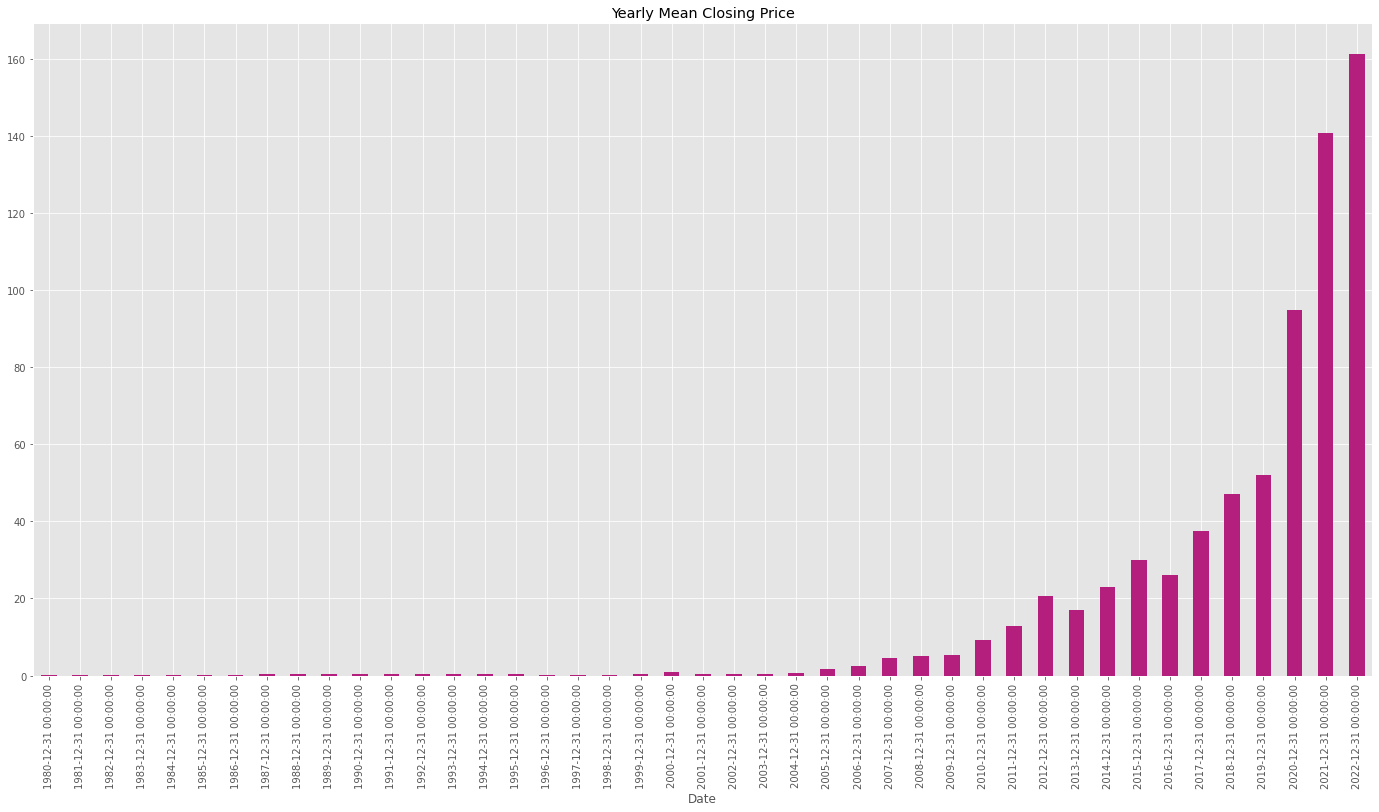

In [18]:
title = 'Yearly Mean Closing Price'
df['Open'].resample('A').mean().plot.bar(title=title,color=['#b41f7d'] , figsize=(24,12));

In [19]:
df['6-month-SMA'] = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA'] = df['Open'].rolling(window=2).mean()

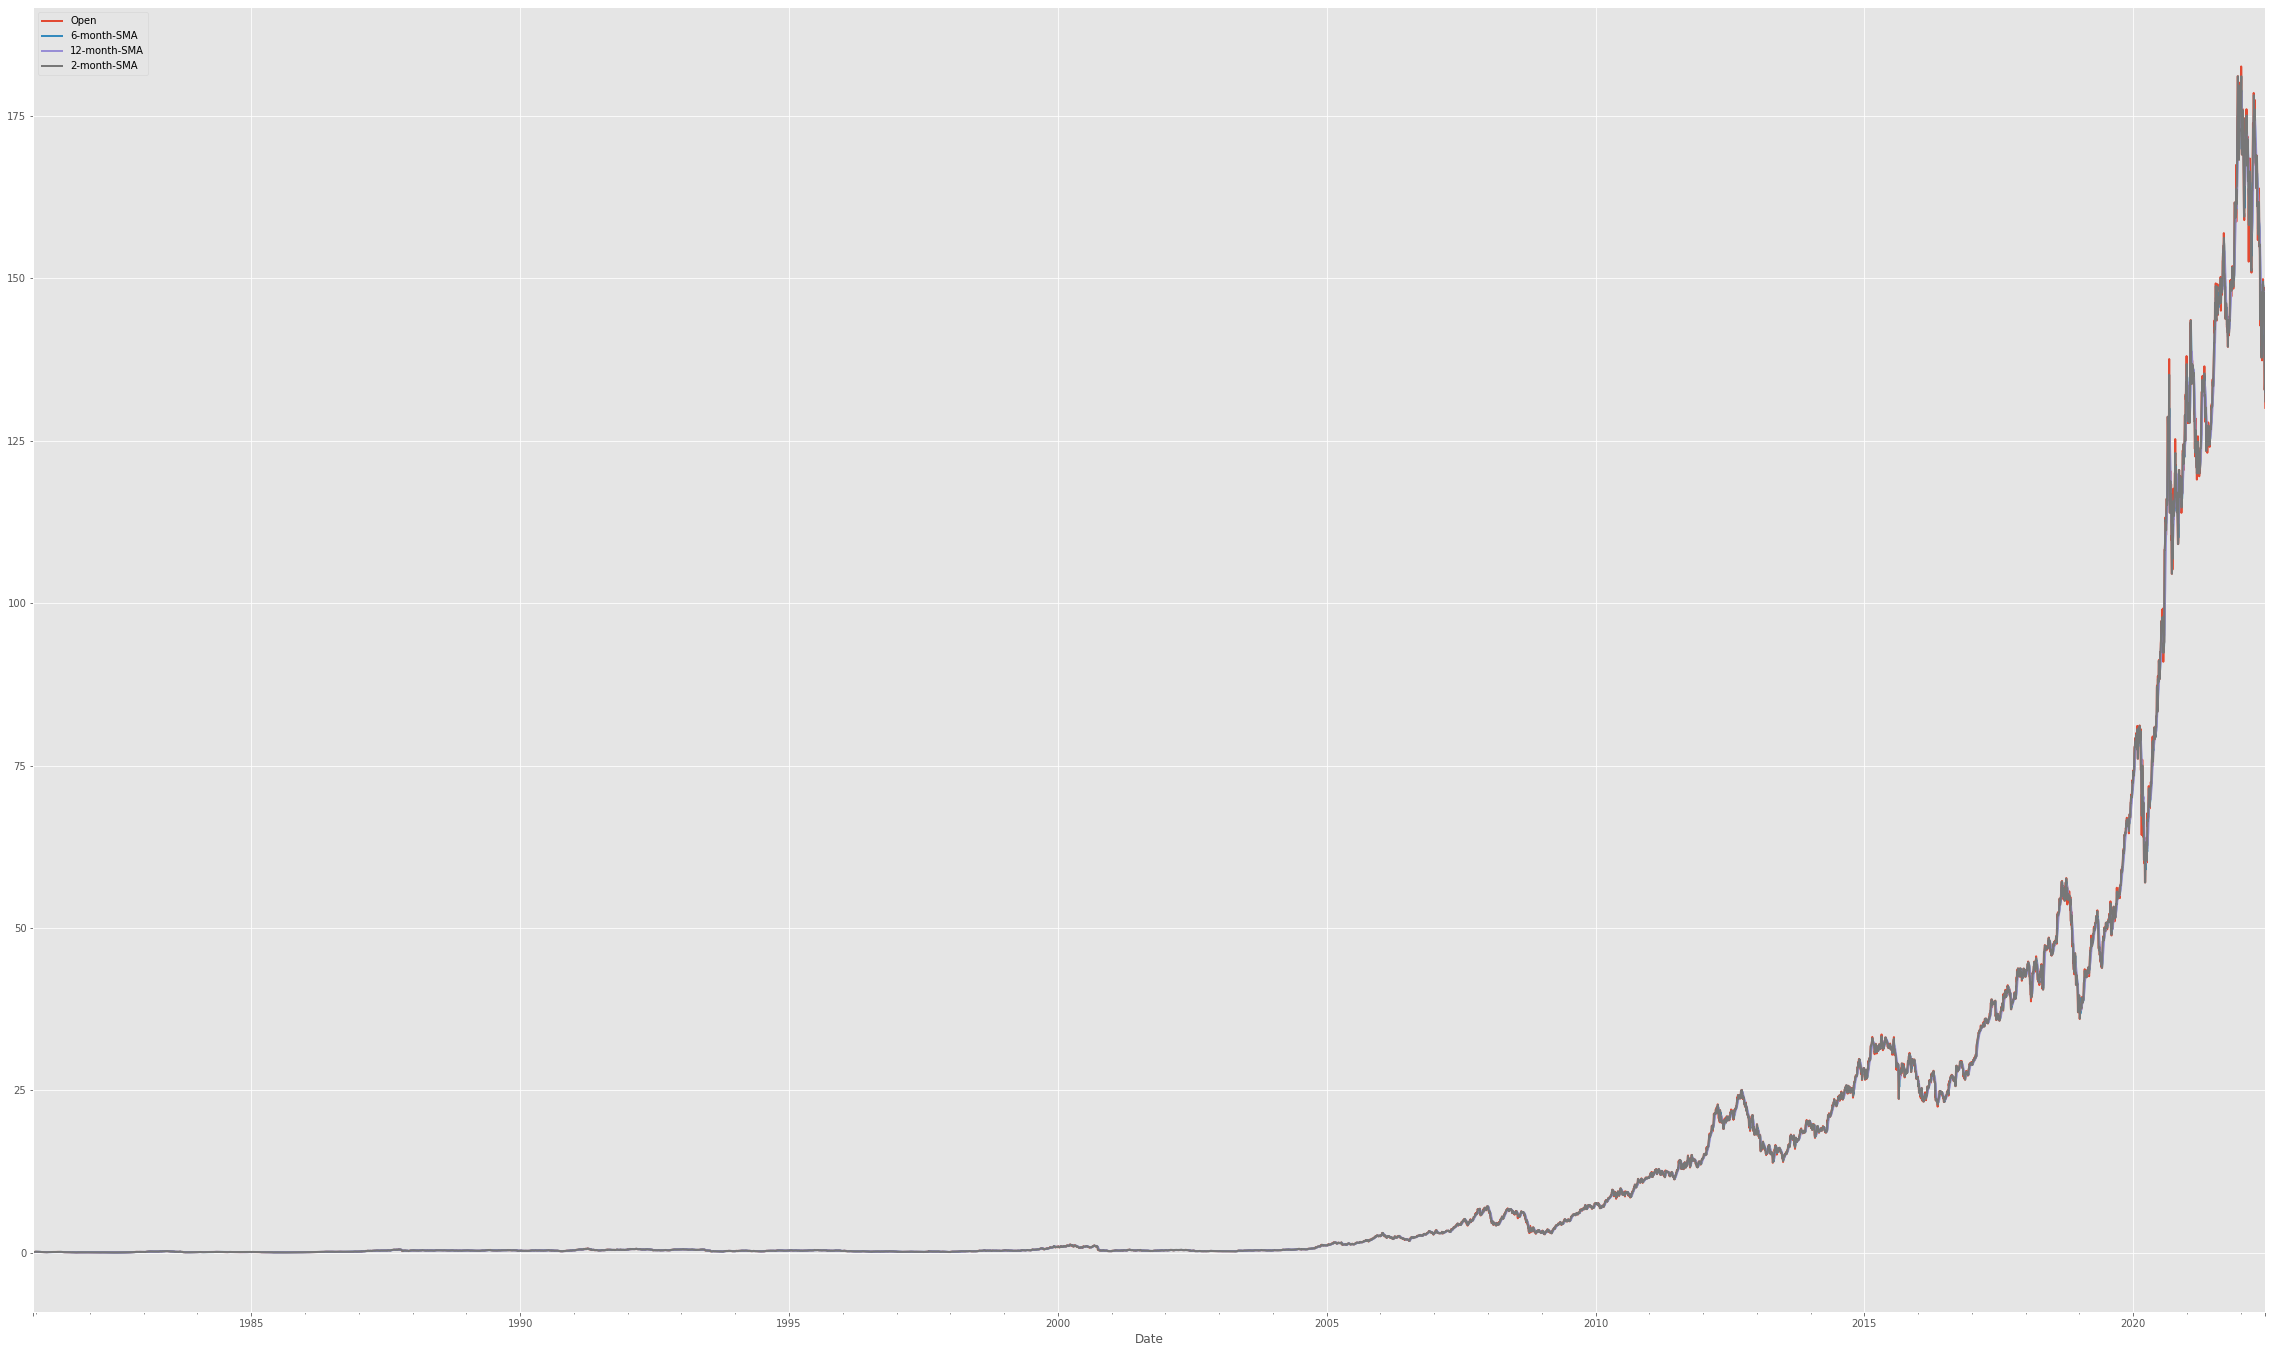

In [20]:
df[["Open","6-month-SMA","12-month-SMA","2-month-SMA"]].plot(figsize=(40,24));

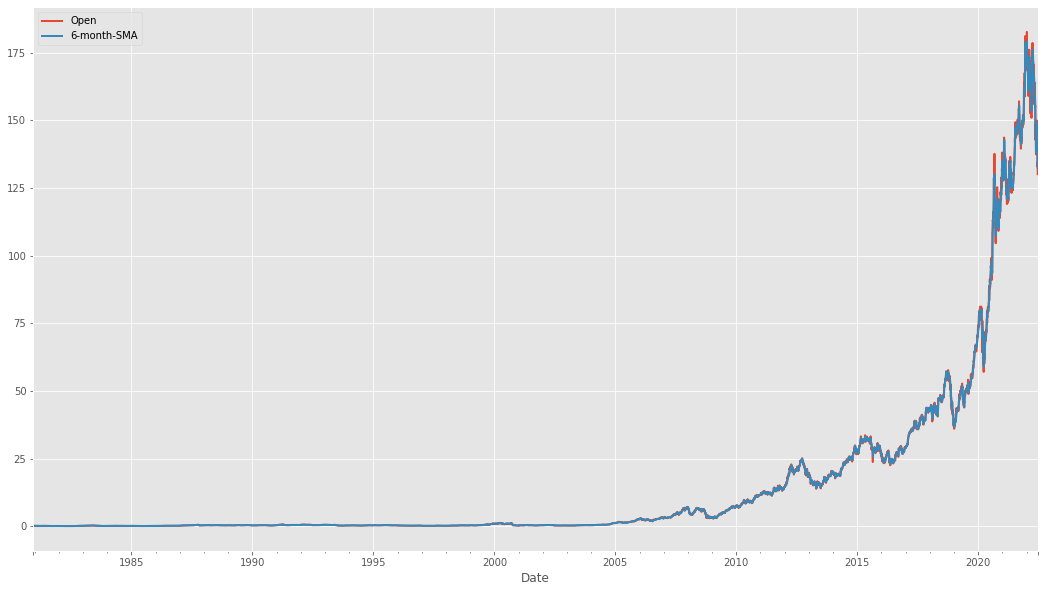

In [21]:
df[["Open","6-month-SMA"]].plot(figsize=(18,10));

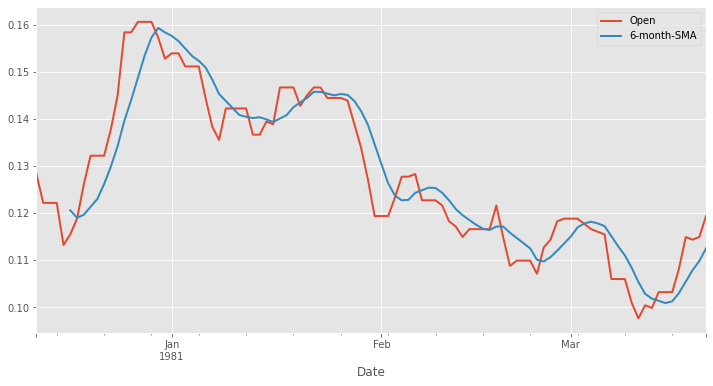

In [22]:
df[['Open','6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [23]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()

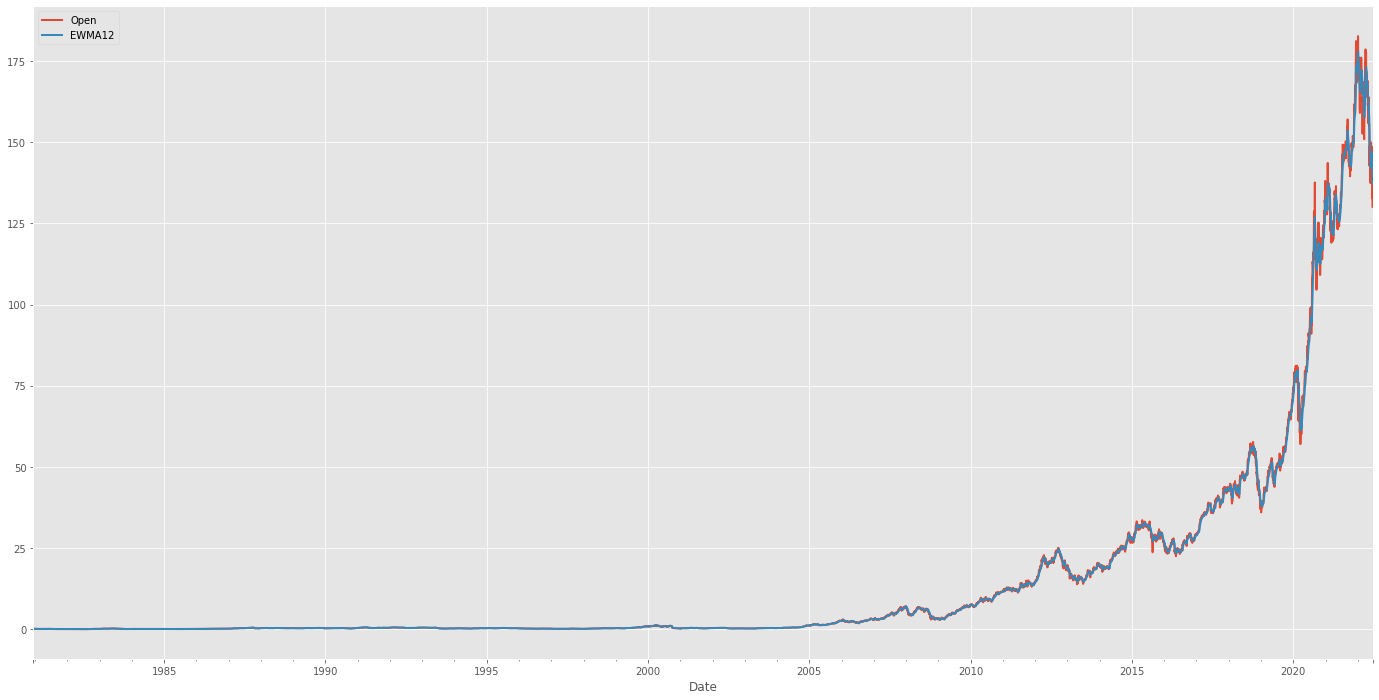

In [24]:
df[['Open','EWMA12']].plot(figsize=(24,12));

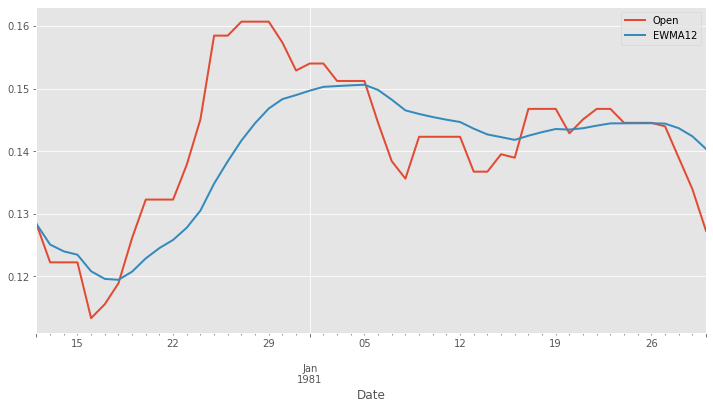

In [25]:
df[['Open','EWMA12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [26]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()

In [27]:
span = 8
alpha = 2/(span+1)

In [28]:
df['EWMA12'] = df['Open'].ewm(alpha=alpha,adjust=False).mean()

In [29]:
model=SimpleExpSmoothing(df["Open"])

In [30]:
model.fit(smoothing_level=alpha,optimized=False)

In [31]:
fitted_model=model.fit(smoothing_level=alpha,optimized=False)

In [32]:
fitted_model.fittedvalues

Date
1980-12-12      0.128348
1980-12-13      0.128348
1980-12-14      0.126984
1980-12-15      0.125923
1980-12-16      0.125098
                 ...    
2022-06-13    140.496869
2022-06-14    138.802008
2022-06-15    137.541563
2022-06-16    136.818992
2022-06-17    135.765883
Freq: D, Length: 15163, dtype: float64

In [33]:
fitted_model.fittedvalues.shift(-1)

Date
1980-12-12      0.128348
1980-12-13      0.126984
1980-12-14      0.125923
1980-12-15      0.125098
1980-12-16      0.122472
                 ...    
2022-06-13    138.802008
2022-06-14    137.541563
2022-06-15    136.818992
2022-06-16    135.765883
2022-06-17           NaN
Freq: D, Length: 15163, dtype: float64

In [34]:
df["SES12"]=fitted_model.fittedvalues.shift(-1)

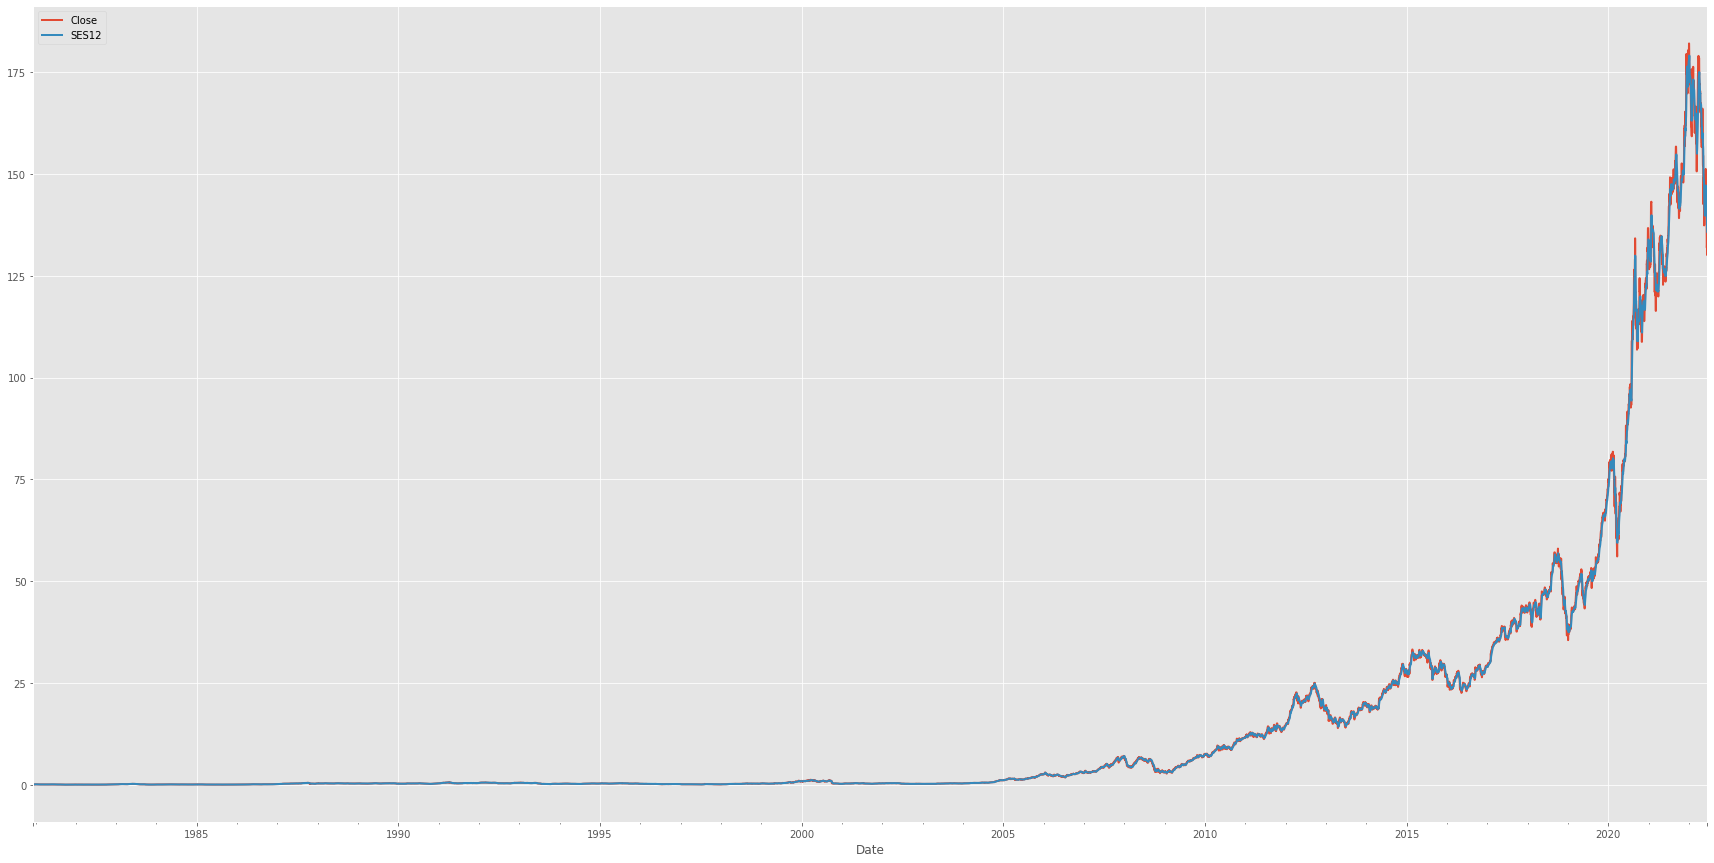

In [35]:
df[['Close',"SES12"]].plot(figsize=(30,15)).autoscale(axis='x',tight=True);

In [36]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12
Date,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.128963
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.123068
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.122861
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.122854
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.114235


<AxesSubplot:xlabel='Date'>

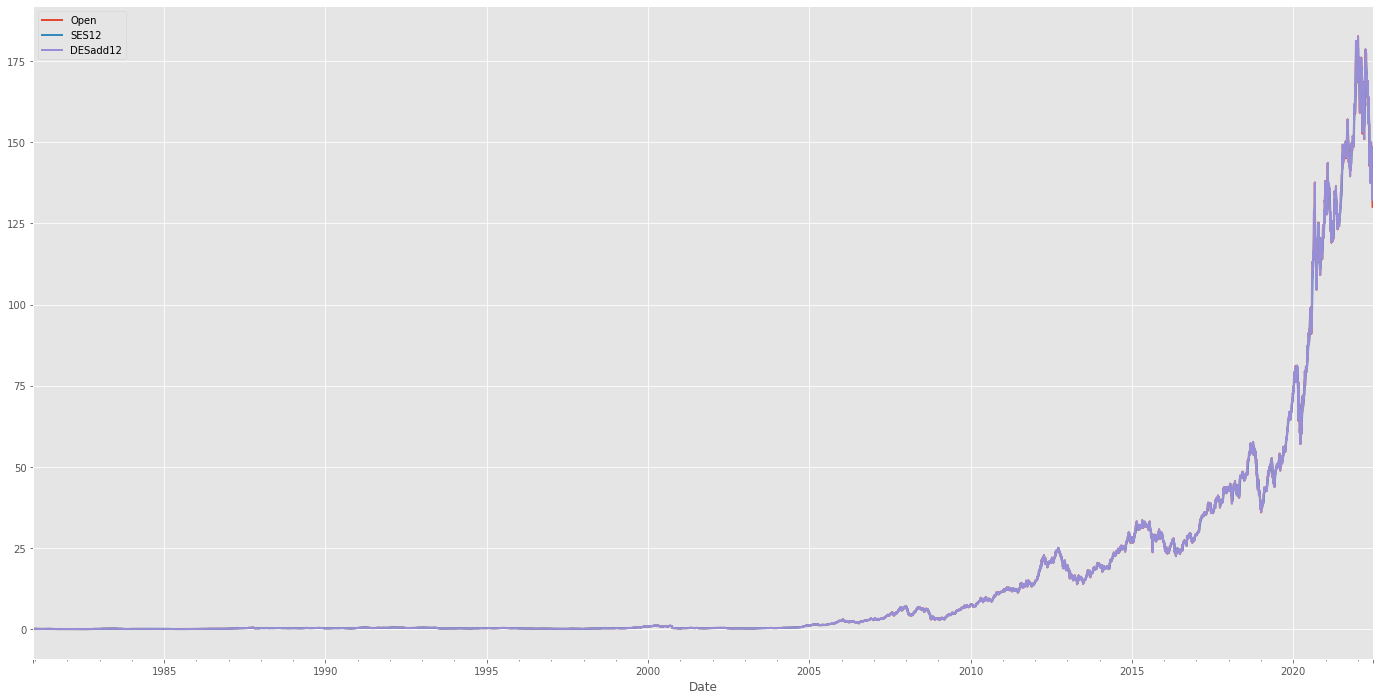

In [37]:
df[['Open',  'SES12', 'DESadd12']].plot(figsize=(24,12))

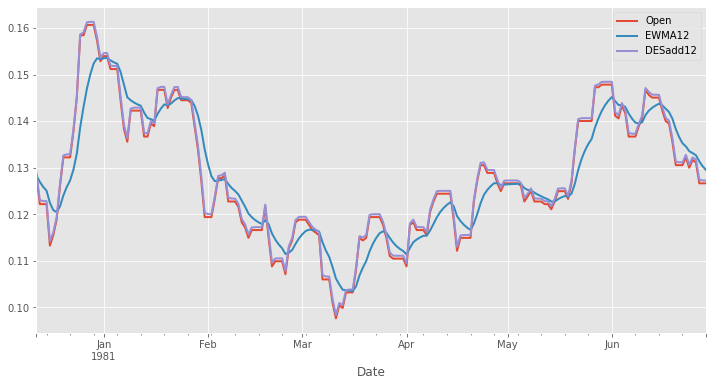

In [38]:
df[['Open','EWMA12','DESadd12']].iloc[:200].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [39]:
df['DESmul12'] = ExponentialSmoothing(df['Open'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Date,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.128963,NaN
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.123068,NaN
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.122861,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.122854,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.114235,NaN


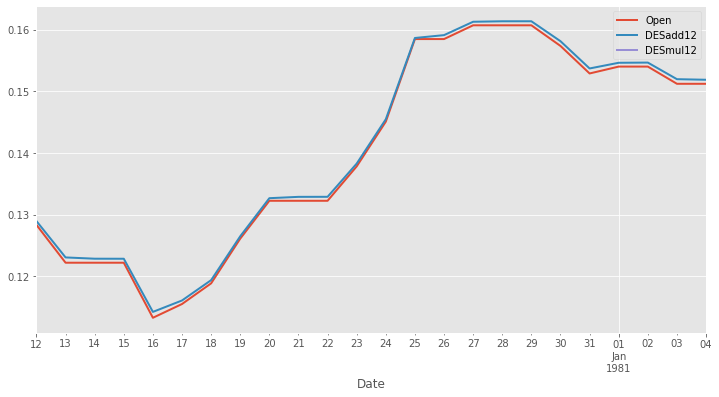

In [40]:
df[['Open','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [41]:
df['TESadd12'] = ExponentialSmoothing(df['Open'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Date,,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.128963,NaN,0.129035
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.123068,NaN,0.126688
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.122861,NaN,0.120261
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.122854,NaN,0.125955
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.114235,NaN,0.133614


In [42]:
df['TESmul12'] = ExponentialSmoothing(df['Open'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Date,,,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600.0,4.690336e+08,NaN,NaN,NaN,NaN,0.128348,0.128348,0.128963,NaN,0.129035,NaN
1980-12-13,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,-0.625006,NaN,NaN,0.125279,0.126984,0.126984,0.123068,NaN,0.126688,NaN
1980-12-14,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125923,0.125923,0.122861,NaN,0.120261,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800.0,1.758848e+08,0.000000,NaN,NaN,0.122210,0.125098,0.125098,0.122854,NaN,0.125955,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000.0,1.057280e+08,-0.398879,NaN,NaN,0.117746,0.122472,0.122472,0.114235,NaN,0.133614,NaN


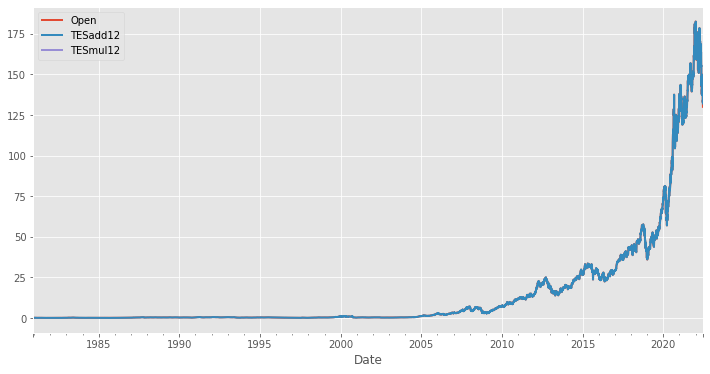

In [43]:
df[['Open','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

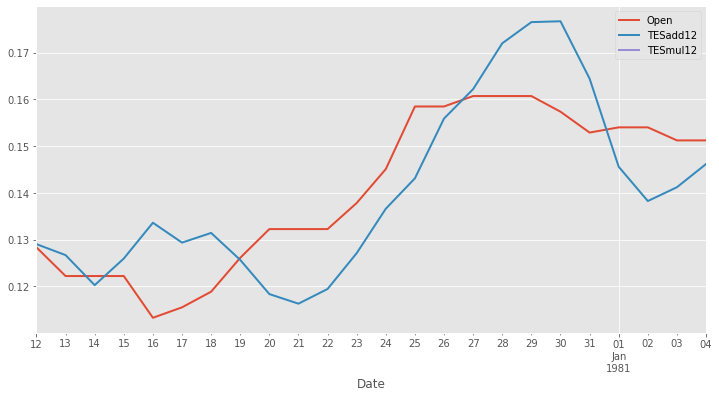

In [44]:
df[['Open','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# LSTM MODEL

In [45]:
data = df.filter(['Open'])

dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

14405

In [46]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[4.30950014e-04],
       [3.97331936e-04],
       [3.97331936e-04],
       ...,
       [7.35239774e-01],
       [7.23135563e-01],
       [7.12126738e-01]])

In [47]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00043095, 0.00039733, 0.00039733, 0.00039733, 0.00034843,
       0.00036065, 0.00037899, 0.00041873, 0.00045234, 0.00045234,
       0.00045234, 0.00048291, 0.00052264, 0.000596  , 0.000596  ,
       0.00060822, 0.00060822, 0.00060822, 0.00058988, 0.00056543,
       0.00057155, 0.00057155, 0.00055626, 0.00055626, 0.00055626,
       0.00051958, 0.00048597, 0.00047069, 0.00050736, 0.00050736,
       0.00050736, 0.00050736, 0.0004768 , 0.0004768 , 0.00049208,
       0.00048902, 0.00053181, 0.00053181, 0.00053181, 0.00051042,
       0.00052264, 0.00053181, 0.00053181, 0.00051958, 0.00051958,
       0.00051958, 0.00051653, 0.00048902, 0.00046152, 0.00042484,
       0.00038205, 0.00038205, 0.00038205, 0.00040344, 0.00042789,
       0.00042789, 0.00043095, 0.00040039, 0.00040039, 0.00040039])]
[0.0003942757473230688]

[array([0.00043095, 0.00039733, 0.00039733, 0.00039733, 0.00034843,
       0.00036065, 0.00037899, 0.00041873, 0.00045234, 0.00045234,
       0.00045234, 0.00048291, 0.

In [48]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [49]:
history =model.fit(x_train, y_train, 
                        epochs=100,
                        batch_size=32,
                        )

Epoch 1/100
449/449 [==============================] - 17s 7ms/step - loss: 0.0011
Epoch 2/100
449/449 [==============================] - 3s 7ms/step - loss: 1.5717e-05
Epoch 3/100
449/449 [==============================] - 4s 9ms/step - loss: 1.8054e-05
Epoch 4/100
449/449 [==============================] - 3s 7ms/step - loss: 1.2397e-05
Epoch 5/100
449/449 [==============================] - 3s 7ms/step - loss: 9.7844e-06
Epoch 6/100
449/449 [==============================] - 3s 7ms/step - loss: 1.0374e-05
Epoch 7/100
449/449 [==============================] - 3s 7ms/step - loss: 1.1495e-05
Epoch 8/100
449/449 [==============================] - 3s 7ms/step - loss: 9.6050e-06
Epoch 9/100
449/449 [==============================] - 3s 7ms/step - loss: 7.6682e-06
Epoch 10/100
449/449 [==============================] - 3s 7ms/step - loss: 8.3238e-06
Epoch 11/100
449/449 [==============================] - 3s 7ms/step - loss: 7.0696e-06
Epoch 12/100
449/449 [==============================] -

In [50]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)
print(mean_absolute_error(y_test, predictions))



8.18176234785231
6.858671056648999


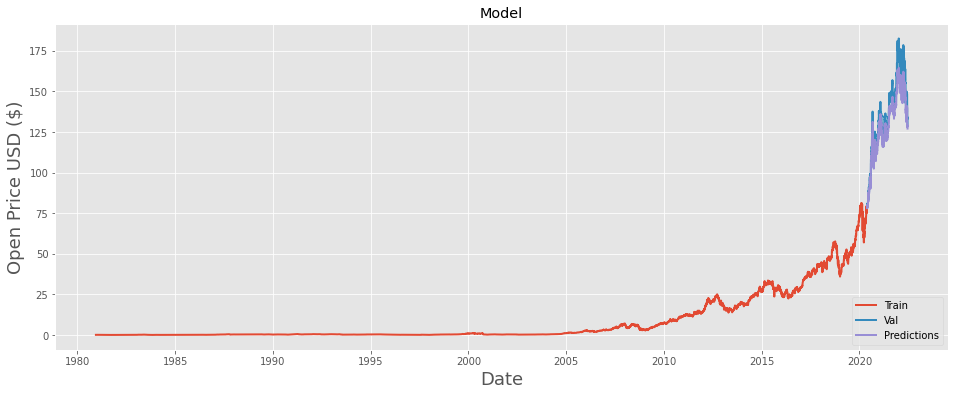

In [51]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

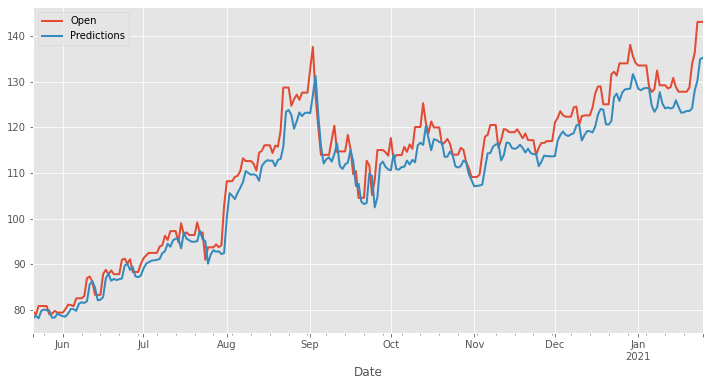

In [52]:
valid[['Open','Predictions']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x',tight=True);